In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
import numpy as np

# import string

# for text cleaning and preprocessing
import re 
# NLTK for NLP utils and corpora
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import urllib.request
import httplib2
import requests
from requests.exceptions import ConnectionError, RequestException
from bs4 import BeautifulSoup, SoupStrainer
import csv
import time
import re  #https://regex101.com/
import unicodedata


# sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Libraries for Baseline MNB
# from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn import metrics

# Libraries for LSTM/CNN/RNN
import tensorflow as tf
from tensorflow import keras
from tflearn.data_utils import VocabularyProcessor
from tensorflow.contrib import learn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Helper libraries from w266 common
import utils, vocabulary, tf_embed_viz, treeviz
import patched_numpy_io

# for word embeddings
import gensim

from gensim.models import word2vec
import vocabulary


In [193]:
# run script to scrape comments from reddit
# %run -i 'reddit_comment_scraper.py'

# Exploratory Data Analysis

In [194]:
# load csv of scraped comments
df = pd.read_csv('data/reddit/reddit_comments.csv')

In [195]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,url,tournament,team_1,team_2,comment,controversiality,score,gilded,top_level_replies,vader_negative,vader_neutral,vader_positivity,vader_compound,tb_polarity,tb_subjectivity
0,https://www.reddit.com/r/soccer/comments/c8cy9...,1,england,united,Goal ruled out for offside. \n\nMissed a penal...,0,1184,0,4,0.224,0.776,0.000,-0.6696,0.250000,0.250000
1,https://www.reddit.com/r/soccer/comments/c8cy9...,1,england,united,Dutch commentators just shared a fun fact: the...,0,891,0,2,0.000,0.815,0.185,0.8779,0.061458,0.486458
2,https://www.reddit.com/r/soccer/comments/c8cy9...,1,england,united,For anyone that is playing bingo. We had a sch...,0,709,0,3,0.000,0.913,0.087,0.2023,0.000000,0.000000
3,https://www.reddit.com/r/soccer/comments/c8cy9...,1,england,united,"So, just checking, am I in the right thread fo...",0,2920,0,4,0.132,0.868,0.000,-0.5423,0.285714,0.535714
4,https://www.reddit.com/r/soccer/comments/c8cy9...,1,england,united,I hope everyone here divulges into nonsensical...,0,1606,0,3,0.211,0.650,0.139,-0.5106,0.091667,0.391667


In [196]:
df.describe()

,tournament,controversiality,score,gilded,top_level_replies,vader_negative,vader_neutral,vader_positivity,vader_compound,tb_polarity,tb_subjectivity
count,15330.000000,15330.000000,15330.000000,15330.000000,15330.000000,15330.000000,15330.000000,15330.000000,15330.000000,15330.000000,15330.000000
mean,0.503392,0.001239,26.377952,0.000326,0.592433,0.116061,0.736299,0.147249,0.061927,0.053363,0.404621
std,0.500005,0.035184,90.292493,0.018057,0.802075,0.171158,0.220451,0.185237,0.451567,0.335092,0.336001
min,0.000000,0.000000,-39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.999300,-1.000000,0.000000
25%,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.591000,0.000000,-0.267150,-0.033333,0.000000
50%,1.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.742000,0.079000,0.000000,0.000000,0.425000
75%,1.000000,0.000000,18.000000,0.000000,1.000000,0.202000,1.000000,0.255000,0.440400,0.200000,0.666667
max,1.000000,1.000000,2920.000000,1.000000,12.000000,1.000000,1.000000,1.000000,0.995300,1.000000,1.000000


In [197]:
df.groupby(['tournament']).size()

tournament
0    7613
1    7717
dtype: int64

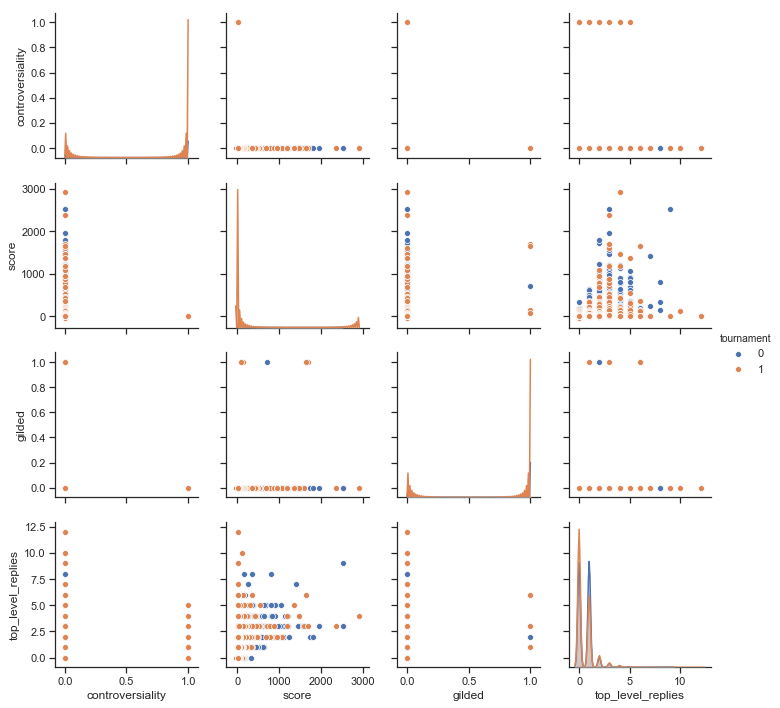

In [198]:
reddit_props = ['controversiality', 'score', 'gilded', 'top_level_replies']
sentiment_values = ['vader_negative', 'vader_neutral', 'vader_positivity',
                    'vader_compound','tb_polarity', 'tb_subjectivity']

sns.pairplot(df, vars=reddit_props, hue="tournament")

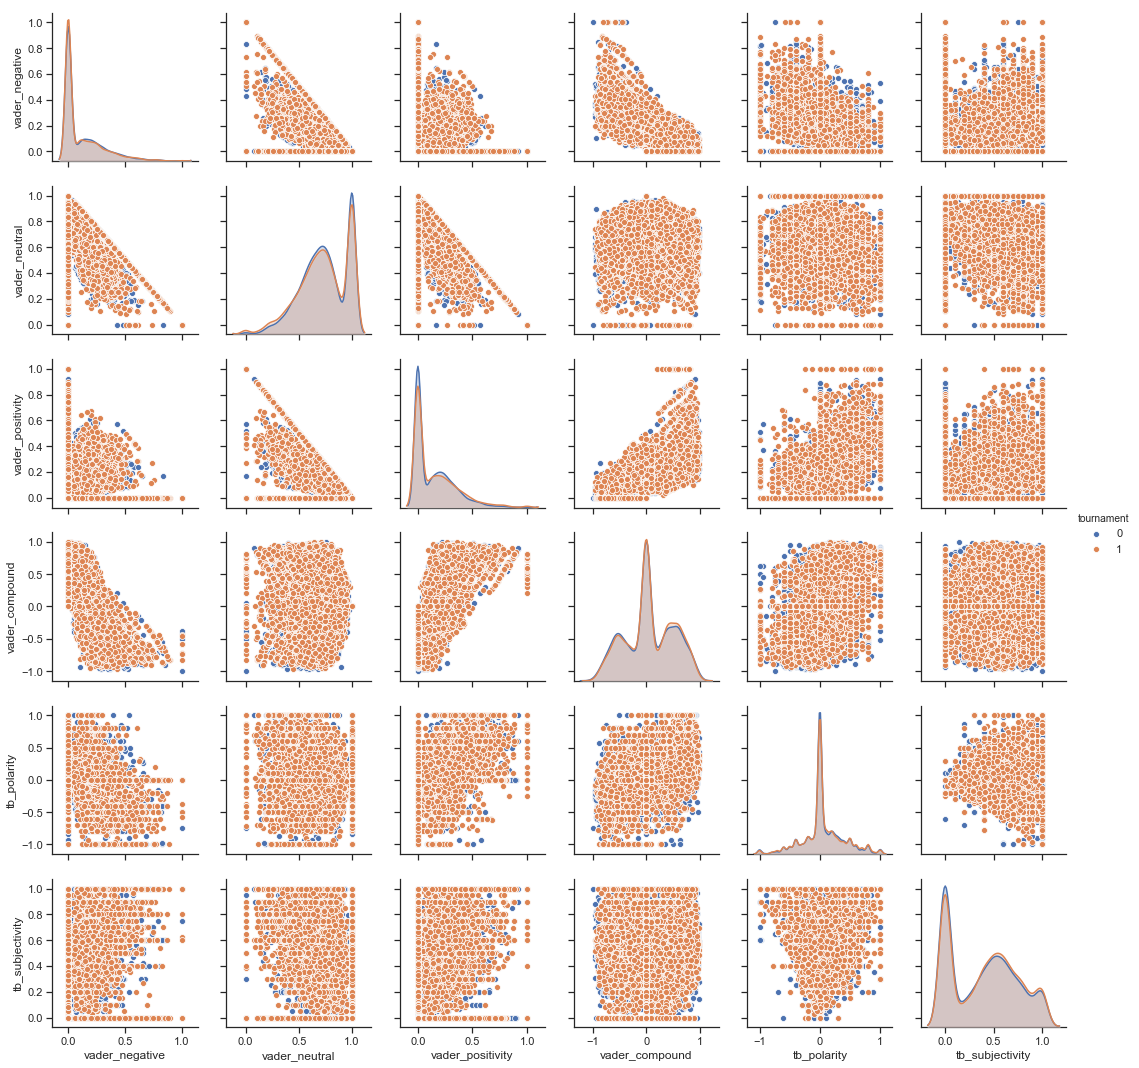

In [199]:
sns.pairplot(df, vars=sentiment_values, hue="tournament")

In [200]:
df.groupby(['tournament'])[sentiment_values].describe().T

tournament                        0            1
vader_negative   count  7613.000000  7717.000000
                 mean      0.117891     0.114255
                 std       0.170517     0.171781
                 min       0.000000     0.000000
                 25%       0.000000     0.000000
                 50%       0.000000     0.000000
                 75%       0.205000     0.197000
                 max       1.000000     1.000000
vader_neutral    count  7613.000000  7717.000000
                 mean      0.742286     0.730392
                 std       0.212686     0.227713
                 min       0.000000     0.000000
                 25%       0.599000     0.588000
                 50%       0.744000     0.741000
                 75%       1.000000     1.000000
                 max       1.000000     1.000000
vader_positivity count  7613.000000  7717.000000
                 mean      0.139171     0.155217
                 std       0.173499     0.195815
                 min       0.000000     0.000000
                 25%       0.000000     0.000000
                 50%       0.069000     0.086000
                 75%       0.245000     0.265000
                 max       1.000000     1.000000
vader_compound   count  7613.000000  7717.000000
                 mean      0.054995     0.068766
                 std       0.454093     0.448985
                 min      -0.999300    -0.964600
                 25%      -0.273200    -0.250000
                 50%       0.000000     0.000000
                 75%       0.427800     0.440400
                 max       0.991700     0.995300
tb_polarity      count  7613.000000  7717.000000
                 mean      0.050641     0.056048
                 std       0.331593     0.338508
                 min      -1.000000    -1.000000
                 25%      -0.033333    -0.038095
                 50%       0.000000     0.000000
                 75%       0.200000     0.200000
                 max       1.000000     1.000000
tb_subjectivity  count  7613.000000  7717.000000
                 mean      0.394944     0.414168
                 std       0.335878     0.335871
                 min       0.000000     0.000000
                 25%       0.000000     0.000000
                 50%       0.400000     0.446667
                 75%       0.650000     0.666667
                 max       1.000000     1.000000

In [201]:
df.groupby(df.tournament)['controversiality'].value_counts()

tournament  controversiality
0           0                   7611
            1                      2
1           0                   7700
            1                     17
Name: controversiality, dtype: int64

## Example comments

In [202]:
print("Women's World Cup match thread comments")
for i in range(5):
    print("Comment example {}: \n".format(i+1), df[df.tournament == 1]['comment'][i], "\n")
    
print("Men's World Cup match thread comments")
for j in range(5):
    print("Comment example {}: \n".format(j+1), df[df.tournament == 0]['comment'][7717+j], "\n")

Women's World Cup match thread comments
Comment example 1: 
 Goal ruled out for offside. 

Missed a penalty. 

Player sent off. 



This is the most English way to go out of a tournament! 

Comment example 2: 
 Dutch commentators just shared a fun fact: the team that kept a clean sheet against the US for the longest this tournament was in fact Thailand. The first goal in that game fell in the thirteenth minute; the us scored earlier in all other matches. Clearly US-Thailand was the *real* final of this world cup 

Comment example 3: 
 For anyone that is playing bingo. We had a school shooting comment by u/clear_list however they or the mods deleted it. 

Comment example 4: 
 So, just checking, am I in the right thread for where a Texan with a Man Utd flair is called a wanker by a Londoner with a Man Utd flair? 

Comment example 5: 
 I hope everyone here divulges into nonsensical personal attacks on each other and genuinely wishes death upon every citizen of both nations. It is your dut

# Baseline Model: Naive Bayes

In [203]:
# Randomly mixing data&labels so that they can be split into test and train
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [205]:
def split_train_dev_test(data, labels):
    """takes data and given labels and splits into 80% train, 10%dev, and 10% test sets
    
    returns split data and labels
    """
    X, y = shuffle_in_unison(data, labels)
    sev = int(len(data)*.8)
    fif = int(len(data)*.1)
    x_train = X[:sev]
    y_train = y[:sev]
    x_dev = X[sev:sev+fif]
    y_dev = y[sev:sev+fif]
    x_test = X[sev+fif:]
    y_test = y[sev+fif:]
    
    return x_train, y_train, x_dev, y_dev, x_test, y_test

In [206]:
def train_test_split(data, labels, pct=.8):
    """takes data and given labels and splits into 80% train, 20% test sets
    
    returns split data and labels
    """
    X, y = shuffle_in_unison(data, labels)
    split = int(len(X)*pct)
    x_train = X[:split]
    y_train = y[:split]
    x_test = X[split:]
    y_test = y[split:]
    
    return x_train, y_train, x_test, y_test

In [204]:
comments = np.array(df['comment'])
labels = np.array(df['tournament'])

In [207]:
# Split data into train (80%), dev (10%), test (10%)

X_train, y_train, X_dev, y_dev, X_test, y_test = split_train_dev_test(comments, labels)

print(comments.shape)
print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

(15330,)
(12264,)
(1533,)
(1533,)


In [208]:
def print_results(vectorizer, data, label=""):
    """takes a vectorizer and a list of strings and returns prints out descriptions of the vectorixed data
    descriptions include:
        vocabulary size, average number of non-zero vectors, shape of teh matrix, 
        fraction of non zero values, first feature string, last feature string
    
    Args:
        vectorizer(fucntion): vectorizer function to be used to produce feature vectors
        
        data(array): array of strings to be turned into feature vectors
        
    Kwargs:
        label(string): label to be added to print statement 
    
    returns:
        none: prints out specified information
    
    """
    # fit the data using specified vectorizer
    v_data = vectorizer.fit_transform(data)
    
    print(f"""
Count vectorizer of {label}
    The vocaublary size is: {len(vectorizer.get_feature_names())}
    The average number of non zero values is: {v_data.nnz/len(data)}
    The shape of the matrix is: {v_data.shape}
    The fraction of non zero values is: {v_data.nnz/(v_data.shape[0]* v_data.shape[1])}
    The first feature string is: {vectorizer.get_feature_names()[0]}
    The last feature string is: {vectorizer.get_feature_names()[-1]}    
    """)

In [210]:
from sklearn.feature_extraction.text import *

cv = CountVectorizer()
print_results(cv, X_train, "training data")

cv_bigram = CountVectorizer(ngram_range=(2,2))
print_results(cv_bigram, X_train, "bigramned training data")

cv_trigram = CountVectorizer(ngram_range=(3,3))
print_results(cv_trigram, X_train, "trigramned training data")



Count vectorizer of training data
    The vocaublary size is: 10818
    The average number of non zero values is: 11.857713633398564
    The shape of the matrix is: (12264, 10818)
    The fraction of non zero values is: 0.0010961095982065599
    The first feature string is: 00
    The last feature string is: つcroatia    
    

Count vectorizer of bigramned training data
    The vocaublary size is: 74761
    The average number of non zero values is: 11.708985649054142
    The shape of the matrix is: (12264, 74761)
    The fraction of non zero values is: 0.00015661890088487502
    The first feature string is: 00 even
    The last feature string is: つcroatia take    
    

Count vectorizer of trigramned training data
    The vocaublary size is: 114672
    The average number of non zero values is: 10.818003913894325
    The shape of the matrix is: (12264, 114672)
    The fraction of non zero values is: 9.433866954351825e-05
    The first feature string is: 00 even though
    The last feat

# Text cleaning

In [244]:
def scraper(url):
    """scrapes names of world cup players from wikipedia
    """
    r = urllib.request.urlopen(url)
    soup = BeautifulSoup(r, 'html.parser')
    tags = soup.find_all("th", scope='row')
    
    # Clean text
    names = re.sub("<[^>]*>", "", str(tags), flags=re.MULTILINE)
    names = names.replace('\xa0',' ')
    names = clean_article(names)
    
    return names

In [321]:
womens_teams = ['France', 'Nigeria', 'Norway', 'South Korea', 'China', 'Germany', 'South Africa', 'Spain', 
                'Australia', 'Brazil', 'Italy', 'Jamaica', 'Argentina', 'England', 'Japan', 'Scotland', 
                'Cameroon', 'Canada', 'Netherlands', 'New Zealand','Zealand', 'Chile', 'Sweden', 'Thailand', 
                'United States', 'US', 'uswnt','korea', 'usa', 'dutch', ]

mens_teams = ['argentina','australia','belgium','brazil','egypt','russia','saudi','arabia','uruguay',
             'iran','morocco','portugal','spain','denmark','france','peru','iceland','nigeria','costa rica','serbia',
             'switzerland','germany','mexico', 'south korea','england','sweden','panama','tunisia','colombia','japan',
             'poland', 'senegal', 'croatia']

male_names = ['adolf', 'aguero','agusto',  'aleksandr', 'alexi', 'altidore', 'andres', 'andy', 'anthony', 'antonio', 
              'bale', 'beckham', 'boateng', 'coutinho', 'cristiano', 'griezmann','mbappe','lionel','messi','ronaldo',
             'neymar','luis','suarez','zidane','eden','hazard','sergio','ramos','gareth','bale','diego','maradona',
             'andres','iniesta','kevin','bruyne','paul','pogba','kylian','mbappe','zlatan','ibrahimovic','harry',
              'kane','david','robert','lewandowski','toni','kroos','sergio','aguero','luka','modric','manuel','neuer',
             'mohamed','salah','xavi','gerald','pique','marcelo','vieria','pep','guardiola','gianluigi','buffon',
             'philippe','thibaut','courtois','johan','cruyff','james','rodriguez','leonardo','bonucci','kante',
              'edison',
             'cavani','mesut','ozil','david','silva','dele','ali','giorgio','chiellini','raphael','verane','isco',
              'zico',
             'guzman','armani','franco','caballero','mercado','tagliafico','ansaldi','fazio','acuna','mascherano',
             'marcos','rojo','otamendi','salvio','biglia','banega','meza','enzo','perez','celso','pavon',
             'higuain','aguero','dybala','sampaoli','ryan','jones','vukovic','degenek','meredith','milligan',
              'jurman',
             'behich','risdon','sainsbury','luongo','mooy','jedinak','irvine','rogic','cahill','leckie','juric',
             'kruse','nabbout','maclaren','arzani','petratos','thibaut','courtois','mignolet','casteels',
             'alderweireld','vermaelen','kompany','vertonghen','meurnier','boyata','dendoncker','witsel','fellaini',
             'carrasco','hazard','tielemans','dembele','chadli','lukaku','mertens','januzaj','batshuayi','martinez',
             'becker','cassio','ederson','silva','miranda','geromel','filipe','marcelo','marquinhos','danilo',
             'fagner','casemiro','agusto','paulinho','fernandinho','fred','willian','costa','firmino','taison',
             'Ali', 'Gabr','Ahmed' ,'Elmohamady','Omar', 'Sam', 'Morsy', 'Ahmed', 'Hegazi', 'Ahmed', 'Fathy','Tarek', 
              'Hamed', 'Marwan', 'Mohsen', 'Mohamed', 'Salah', 'Kahraba', 'Ayman', 'Ashraf', 'Mohamed', 'Abdel', 
              'Shafy',
              'Ramadan', 'Sobhi', 'Mahmoud', 'Hamdy', 'Sherif', 'Ekramy', 'Mohamed', 'Elneny', 'Shikabala', 
              'Abdallah',
              'El', 'SaidvSaad', 'Samir', 'Trézéguet', 'Amr', 'Warda', 'Mohamed', 'El', 'Shenawy','Igor', 'Akinfeev', 
              'Mário', 'Fernandes', 'Ilya', 'Kutepov', 'Sergei', 'Ignashevich', 'Andrei', 'Semyonov', 'Denis', 
              'Cheryshev', 'Daler', 'Kuzyayev', 'Yury', 'Gazinsky', 'Alan', 'Dzagoev', 'Fyodor', 'Smolov', 'Roman', 
              'Zobnin', 'Andrey', 'Lunyov', 'Fyodor', 'Kudryashov', 'Vladimir', 'Granat', 'Aleksei', 'Miranchuk', 
              'Anton', 'Miranchuk', 'Aleksandr', 'Golovin', 'Yuri', 'Zhirkov', 'Aleksandr', 'Samedov', 'Vladimir', 
              'Gabulov', 'Aleksandr', 'Yerokhin', 'Artem', 'Dzyuba', 'Igor', 'Smolnikov','Mansoor', 'Al-Harbi', 
              'Osama', 'Hawsawi', 'Ali', 'Al-Bulaihi', 'Omar', 'Hawsawi', 'Mohammed', 'Al-Breik', 'Salman', 
              'Al-Faraj', 
              'Yahya', 'Al-Shehri', 'Hattan', 'Bahebri', 'Mohammad', 'Al-Sahlawi', 'Abdulmalek', 'Al-Khaibri', 
              'Mohamed', 'Kanno', 'Yasser', 'Al-Shahrani', 'Abdullah', 'Otayf', 'Abdullah', 'Al-Khaibari', 'Housain', 
              'Al-Mogahwi', 'Taisir', 'Al-Jassim', 'Salem', 'Al-Dawsari', 'Fahad', 'Al-Muwallad', 'Muhannad', 
              'Assiri',
              'Yasser', 'Al-Mosailem', 'Mohammed', 'Al-Owais', 'Motaz', 'Hawsawi','José', 'Giménez', 'Diego','Godín', 
              'Guillermo', 'Varela', 'Carlos', 'Sánchez', 'Rodrigo', 'Bentancur', 'Cristian', 'Rodríguez', 'Nahitan', 
              'Nández', 'Luis', 'Suárez', 'Giorgian', 'De', 'Arrascaeta', 'Cristhian', 'Stuani', 'Martín', 'Campaña', 
              'Gastón', 'Silva', 'Lucas', 'Torreira', 'Matías', 'Vecino', 'Maxi', 'Pereira', 'Diego', 'Laxalt', 
              'Maxi', 
              'Gómez', 'Sebastián', 'Coates', 'Jonathan', 'Urretaviscaya', 'Edinson', 'Cavani', 'Martín', 'Cáceres', 
              'Martín', 'Silva', 'Motaz', 'Hawsawi','Mehdi', 'Torabi', 'Ehsan', 'Hajsafi', 'Rouzbeh', 'Cheshmi', 
              'Milad', 'Mohammadi', 'Saeid', 'Ezatolahi', 'Masoud', 'Shojaei', 'Morteza', 'Pouraliganji', 'Omid', 
              'Ebrahimi', 'Karim', 'Ansarifard', 'Vahid', 'Amiri', 'Mohammad', 'Rashid', 'Mazaheri', 'Mohammad', 
              'Reza', 'Khanzadeh', 'Saman', 'Ghoddos', 'Pejman', 'Montazeri', 'Reza', 'Ghoochannejhad', 'Mehdi', 
              'Taremi', 'Alireza', 'Jahanbakhsh', 'Majid', 'Hosseini', 'Sardar', 'Azmoun', 'Ashkan', 'Dejagah', 
              'Amir', 'Abedzadeh', 'Ramin', 'Rezaeian', 'Motaz', 'Hawsawi','Achraf', 'Hakimi', 'Hamza', 'Mendyl', 
              'Manuel', 'da', 'Costa', 'Medhi', 'Benatia', 'Romain', 'Saïss', 'Hakim', 'Ziyech', 'Karim', 'El', 
              'Ahmadi', 'Ayoub', 'El', 'Kaabi', 'Younès', 'Belhanda', 'Fayçal', 'Fajr', 'Munir', 'Mohamedi','Khalid', 
              'Boutaïb', 'Mbark', 'Boussoufa', 'Youssef', 'Aït', 'Bennasser', 'Nordin', 'Amrabat', 'Nabil', 'Dirar', 
              'Amine', 'Harit', 'Youssef', 'En-Nesyri', 'Aziz', 'Bouhaddouz', 'Sofyan', 'Amrabat', 'Ahmed', 'Reda', 
              'Tagnaouti', 'Mehdi', 'Carcela','Bruno', 'Alves', 'Pepe', 'Manuel', 'Fernandes', 'Raphaël','Guerreiro', 
              'José', 'Fonte', 'Cristiano', 'Ronaldo', 'João', 'Moutinho', 'André', 'Silva', 'João', 'Mário', 
              'Bernardo', 
              'Silva', 'Anthony', 'Lopes', 'Rúben', 'Dias', 'William', 'Carvalho', 'Ricardo', 'Pereira', 'Bruno', 
              'Fernandes', 
              'Gonçalo', 'Guedes', 'Gelson', 'Martins', 'Mário', 'Rui', 'Ricardo', 'Quaresma', 'Cédric', 'Beto', 
              'Adrien', 'Silva','Dani', 'Carvajal', 'Gerard', 'Piqué', 'Nacho', 'Sergio', 'Busquets', 'Andrés', 
              'Iniesta', 'Saúl', 'Koke', 'Rodrigo', 'Thiago', 'Lucas', 'Vázquez', 'Álvaro', 'Odriozola', 'Kepa', 
              'Arrizabalaga', 'César', 'Azpilicueta', 'Sergio', 'Ramos', 'Nacho', 'Monreal', 'Iago', 'Aspas', 
              'Jordi', 'Alba', 'Diego', 'Costa', 'Marco', 'Asensio', 'David', 'Silva', 'Isco', 'Pepe', 'Reina',
              'Kasper', 'Schmeichel', 'Michael', 'Krohn-Dehli', 'Jannik', 'Vestergaard', 'Simon', 'Kjær', 'Jonas', 
              'Knudsen', 'Andreas', 'Christensen', 'William', 'Kvist', 'Thomas', 'Delaney', 'Nicolai', 'Jørgensen', 
              'Christian', 'Eriksen', 'Martin', 'Braithwaite', 'Kasper', 'Dolberg', 'Mathias', 'Jørgensen', 'Henrik',
              'Dalsgaard', 'Viktor', 'Fischer', 'Jonas', 'Lössl', 'Jens', 'Stryger', 'Larsen', 'Lukas', 'Lerager',
              'Lasse', 'Schöne', 'Yussuf', 'Poulsen', 'Andreas', 'Cornelius', 'Frederik', 'Rønnow', 'Pione', 'Sisto',
              'Hugo', 'Lloris', 'Benjamin', 'Pavard', 'Presnel', 'Kimpembe', 'Raphaël', 'Varane', 'Samuel', 'Umtiti', 
              'Paul', 'Pogba', 'Antoine', 'Griezmann', 'Thomas', 'Lemar', 'Olivier', 'Giroud', 'Kylian', 'Mbappé', 
              'Ousmane', 'Dembélé', 'Corentin', 'Tolisso', 'Golo', 'Kanté', 'Blaise', 'Matuidi', 'Steven', 'Nzonzi', 
              'Steve', 'Mandanda', 'Adil', 'Rami', 'Nabil', 'Fekir', 'Djibril', 'Sidibé', 'Florian', 'Thauvin', 
              'Lucas', 'Hernandez', 'Benjamin', 'Mendy', 'Alphonse', 'Areola','Pedro', 'Gallese', 'Alberto', 
              'Rodríguez', 
              'Aldo', 'Corzo', 'Anderson', 'Santamaría', 'Miguel', 'Araujo', 'Miguel', 'Trauco', 'Paolo', 'Hurtado', 
              'Christian', 'Cueva', 'Paolo', 'Guerrero', 'Jefferson', 'Farfán', 'Raúl', 'Ruidíaz', 'Carlos','Cáceda', 
              'Renato', 'Tapia', 'Andy', 'Polo', 'Christian', 'Ramos', 'Wilder', 'Cartagena', 'Luis', 'Advíncula', 
              'André', 
              'Carrillo', 'Yoshimar', 'Yotún', 'Edison', 'Flores', 'José', 'Carvallo', 'Nilson', 'Loyola', 'Pedro', 
              'Aquino','Dominik', 'Livaković', 'Šime', 'Vrsaljko', 'Ivan', 'Strinić', 'Ivan', 'Perišić', 'Vedran', 
              'Ćorluka', 'Dejan', 'Lovren', 'Ivan', 'Rakitić', 'Mateo', 'Kovačić', 'Andrej', 'Kramarić', 'Luka', 
              'Modrić', 'Marcelo', 'Brozović', 'Lovre', 'Kalinić', 'Tin', 'Jedvaj', 'Filip', 'Bradarić', 'Duje', 
              'Ćaleta-Car', 'Nikola', 'Kalinić', 'Mario', 'Mandžukić', 'Ante', 'Rebić', 'Milan', 'Badelj', 'Marko', 
              'Pjaca', 'Domagoj', 'Vida', 'Josip', 'Pivarić', 'Danijel', 'Subašić','Hannes', 'Þór', 'Halldórsson', 
              'Birkir', 'Már', 'Sævarsson', 'Samúel', 'Friðjónsson', 'Albert', 'Guðmundsson', 'Sverrir', 'Ingi', 
              'Ingason', 'Ragnar', 'Sigurðsson', 'Jóhann', 'Berg', 'Guðmundsson', 'Birkir', 'Bjarnason', 'Björn', 
              'Bergmann', 'Sigurðarson', 'Gylfi', 'Sigurðsson', 'Alfreð', 'Finnbogason', 'Frederik', 'Schram', 
              'Rúnar', 'Alex', 'Rúnarsson', 'Kári', 'Árnason', 'Hólmar', 'Örn', 'Eyjólfsson', 'Ólafur', 'Ingi', 
              'Skúlason', 'Aron', 'Gunnarsson', 'Hörður', 'Björgvin', 'Magnússon', 'Rúrik', 'Gíslason', 'Emil', 
              'Hallfreðsson', 'Arnór', 'Ingvi', 'Traustason', 'Jón', 'Daði', 'Böðvarsson', 'Ari', 'Freyr', 'Skúlason',
              'Ikechukwu', 'Ezenwa', 'Brian', 'Idowu', 'Elderson', 'Echiéjilé', 'Wilfred', 'Ndidi', 'William', 
              'Troost-Ekong', 'Leon', 'Balogun', 'Ahmed', 'Musa', 'Peter', 'Etebo', 'Odion', 'Ighalo', 'John', 
              'Obi', 'Mikel', 'Victor', 'Moses', 'Shehu', 'Abdullahi', 'Simeon', 'Nwankwo', 'Kelechi', 'Iheanacho', 
              'Joel', 'Obi', 'Daniel', 'Akpeyi', 'Ogenyi', 'Onazi', 'Alex', 'Iwobi', 'John', 'Ogu', 'Chidozie', 
              'Awaziem', 'Tyronne', 'Ebuehi', 'Kenneth', 'Omeruo', 'Francis', 'Uzoho','Keylor', 'Navas', 'Johnny', 
              'Acosta', 'Giancarlo', 'González', 'Ian', 'Smith', 'Celso', 'Borges', 'Óscar', 'Duarte', 'Christian', 
              'Bolaños', 'Bryan', 'Oviedo', 'Daniel', 'Colindres', 'Bryan', 'Ruiz', 'Johan', 'Venegas', 'Joel', 
              'Campbell', 'Rodney', 'Wallace', 'Randall', 'Azofeifa', 'Francisco', 'Calvo', 'Cristian', 'Gamboa', 
              'Yeltsin', 'Tejeda', 'Patrick', 'Pemberton', 'Kendall', 'Waston', 'David', 'Guzmán', 'Marco', 'Ureña',
              'Kenner', 'Gutiérrez', 'Leonel', 'Moreira','Vladimir', 'Stojković', 'Antonio', 'Rukavina', 'Duško', 
              'Tošić', 'Luka', 'Milivojević', 'Uroš', 'Spajić', 'Branislav', 'Ivanović', 'Andrija', 'Živković', 
              'Aleksandar', 'Prijović', 'Aleksandar', 'Mitrović', 'Dušan', 'Tadić', 'Aleksandar', 'Kolarov', 
              'Predrag', 'Rajković', 'Miloš', 'Veljković', 'Milan', 'Rodić', 'Nikola', 'Milenković', 'Marko', 
              'Grujić', 'Filip', 'Kostić', 'Nemanja', 'Radonjić', 'Luka', 'Jović', 'Sergej', 'Milinković-Savić', 
              'Nemanja', 'Matić', 'Adem', 'Ljajić', 'Marko', 'Dmitrović','Manuel', 'Neuer', '(captain)', 'Marvin', 
              'Plattenhardt', 'Jonas', 'Hector', 'Matthias', 'Ginter', 'Mats', 'Hummels', 'Sami', 'Khedira', 
              'Julian', 'Draxler', 'Toni', 'Kroos', 'Timo', 'Werner', 'Mesut', 'Özil', 'Marco', 'Reus', 'Kevin', 
              'Trapp', 'Thomas', 'Müller', 'Leon', 'Goretzka', 'Niklas', 'Süle', 'Antonio', 'Rüdiger', 'Jérôme', 
              'Boateng', 'Joshua', 'Kimmich', 'Sebastian', 'Rudy', 'Julian', 'Brandt', 'İlkay', 'Gündoğan', 
              'Marc-André', 'Stegen', 'Mario', 'Gómez', 'José', 'de', 'Jesús', 'Corona', 'Hugo', 'Ayala', 'Carlos', 
              'Salcedo', 'Rafael', 'Márquez', 'Érick', 'Gutiérrez', 'Jonathan', 'dos', 'Santos', 'Miguel', 'Layún', 
              'Marco', 'Fabián', 'Raúl', 'Jiménez', 'Giovani', 'dos', 'Santos', 'Carlos', 'Vela', 'Alfredo', 
              'Talavera', 'Guillermo', 'Ochoa', 'Javier', 'Hernández', 'Héctor', 'Moreno', 'Héctor', 'Herrera', 
              'Jesús', 'Manuel', 'Corona', 'Andrés', 'Guardado', 'Oribe', 'Peralta', 'Javier', 'Aquino', 'Edson', 
              'Álvarez', 'Hirving', 'Lozano', 'Jesús', 'Gallardo', 'Kim', 'Seung-gyu', 'Lee', 'Yong', 'Jung', 
              'Seung-hyun', 'Oh', 'Ban-suk', 'Yun', 'Young-sun', 'Park', 'Joo-ho', 'Son', 'Heung-min', 'Ju', 
              'Se-jong', 'Kim', 'Shin-wook', 'Lee', 'Seung-woo', 'Hwang', 'Hee-chan', 'Kim', 'Min-woo', 'Koo', 
              'Ja-cheol', 'Hong', 'Chul', 'Jung', 'Woo-young', 'Ki', 'Sung-yueng', '(captain)', 'Lee', 'Jae-sung', 
              'Moon', 'Seon-min', 'Kim', 'Young-gwon', 'Jang', 'Hyun-soo', 'Kim', 'Jin-hyeon', 'Go', 'Yo-han', 'Jo', 
              'Hyeon-woo', 'Robin', 'Olsen', 'Mikael', 'Lustig', 'Victor', 'Lindelöf', 'Andreas', 'Granqvist', 
              'Martin', 'Olsson', 'Ludwig', 'Augustinsson', 'Sebastian', 'Larsson', 'Albin', 'Ekdal', 'Marcus', 
              'Berg', 'Emil', 'Forsberg', 'John', 'Guidetti', 'Karl-Johan', 'Johnsson', 'Gustav', 'Svensson', 
              'Filip', 'Helander', 'Oscar', 'Hiljemark', 'Emil', 'Krafth', 'Viktor', 'Claesson', 'Pontus', 
              'Jansson', 'Marcus', 'Rohdén', 'Ola', 'Toivonen', 'Jimmy', 'Durmaz', 'Isaac', 'Kiese', 'Thelin', 
              'Kristoffer', 'Nordfeldt','Jordan', 'Pickford', 'Kyle', 'Walker', 'Danny', 'Rose', 'Eric', 'Dier', 
              'John', 'Stones', 'Harry', 'Maguire', 'Jesse', 'Lingard', 'Jordan', 'Henderson', 'Harry', 'Kane', 
              'Raheem', 'Sterling', 'Jamie', 'Vard', 'Kieran', 'Trippier', 'Jack', 'Butland', 'Danny', 'Welbeck', 
              'Gary', 'Cahill', 'Phil', 'Jones', 'Fabian', 'Delph', 'Ashley', 'Young', 'Marcus', 'Rashford', 'Dele', 
              'Alli', 'Ruben', 'Loftus-Cheek', 'Trent', 'Alexander-Arnold', 'Nick', 'Pope','Jaime', 'Penedo', 
              'Michael', 'Amir', 'Murillo', 'Harold', 'Cummings', 'Fidel', 'Escobar', 'Román', 'Torres', 'Gabriel', 
              'Gómez', 'Blas', 'Pérez', 'Édgar', 'Bárcenas', 'Gabriel', 'Torres', 'Ismael', 'Díaz', 'Armando', 
              'Cooper', 'José', 'Calderón', 'Adolfo', 'Machado', 'Valentín', 'Pimentel', 'Erick', 'Davis', 'Abdiel', 
              'Arroyo', 'Luis', 'Ovalle', 'Luis', 'Tejada', 'Ricardo', 'Ávila', 'Aníbal', 'Godoy', 'José', 'Luis', 
              'Rodríguez', 'Álex', 'Rodríguez', 'Felipe', 'Baloy', 'Farouk', 'Ben', 'Mustapha', 'Syam', 'Ben', 
              'Youssef', 'Yohan', 'Benalouane', 'Yassine', 'Meriah', 'Oussama', 'Haddadi', 'Rami', 'Bedoui', 
              'Saîf-Eddine', 'Khaoui', 'Fakhreddine', 'Ben', 'Youssef', 'Anice', 'Badri', 'Wahbi', 'Khazri', 
              'Dylan', 'Bronn', 'Ali', 'Maâloul', 'Ferjani', 'Sassi', 'Mohamed', 'Amine', 'Ben', 'Amor', 'Ahmed', 
              'Khalil', 'Aymen', 'Mathlouthi', 'Ellyes', 'Skhiri', 'Bassem', 'Srarfi', 'Saber', 
              'Khalifa', 'Ghailene', 'Chaalali', 'Hamdi', 'Nagguez', 'Mouez', 'Hassen', 'Naïm', 'Sliti', 'David', 
              'Ospina', 'Cristián', 'Zapata', 'Óscar', 'Murillo', 'Santiago', 'Arias', 'Wílmar', 'Barrios', 'Carlos', 
              'Sánchez', 'Carlos', 'Bacca', 'Abel', 'Aguilar', 'Radamel', 'Falcao', 'James', 'Rodríguez', 'Juan', 
              'Cuadrado', 'Camilo', 'Vargas', 'Yerry', 'Mina', 'Luis', 'Muriel', 'Mateus', 'Uribe', 'Jefferson', 
              'Lerma', 'Johan', 'Mojica', 'Farid', 'Díaz', 'Miguel', 'Borja', 'Juan', 'Fernando', 'Quintero', 'José', 
              'Izquierdo', 'José', 'Fernando', 'Cuadrado', 'Davinson', 'Sánchez', 'Eiji', 'Kawashima', 'Naomichi', 
              'Ueda', 'Gen', 'Shoji', 'Keisuke', 'Honda', 'Yuto', 'Nagatomo', 'Wataru', 'Endo', 'Gaku', 'Shibasaki', 
              'Genki', 'Haraguchi', 'Shinji', 'Okazaki', 'Shinji', 'Kagawa', 'Takashi', 'Usami', 'Masaaki', 
              'Higashiguchi', 'Yoshinori', 'Muto', 'Takashi', 'Inui', 'Yuya', 'Osako', 'Hotaru', 'Yamaguchi', 
              'Makoto', 'Hasebe', 'Ryota', 'Oshima', 'Hiroki', 'Sakai', 'Tomoaki', 'Makino', 'Gōtoku', 'Sakai', 
              'Maya', 'Yoshida', 'Kosuke', 'Nakamura', 'Wojciech', 'Szczęsny', 'Michał', 'Pazdan', 'Artur', 
              'Jędrzejczyk', 'Thiago', 'Cionek', 'Jan', 'Bednarek', 'Jacek', 'Góralski', 'Arkadiusz', 'Milik', 
              'Karol', 'Linetty', 'Robert', 'Lewandowski', 'Grzegorz', 'Krychowiak', 'Kamil', 'Grosicki', 'Bartosz', 
              'Białkowski', 'Maciej', 'Rybus', 'Łukasz', 'Teodorczyk', 'Kamil', 'Glik', 'Jakub', 'Błaszczykowski', 
              'Sławomir', 'Peszko', 'Bartosz', 'Bereszyński', 'Piotr', 'Zieliński', 'Łukasz', 'Piszczek', 'Rafał', 
              'Kurzawa', 'Łukasz', 'Fabiański', 'Dawid', 'Kownacki', 'Abdoulaye', 'Diallo', 'Adama', 'Mbengue', 
              'Kalidou', 'Koulibaly', 'Kara', 'Mbodji', 'Idrissa', 'Gueye', 'Salif', 'Sané', 'Moussa', 'Sow', 
              'Cheikhou', 'Kouyaté', 'Mame', 'Biram', 'Diouf', 'Sadio', 'Mané', 'Cheikh', "N'Doye", 'Youssouf', 
              'Sabaly', 'Alfred', "N'Diaye", 'Moussa', 'Konaté', 'Diafra', 'Sakho', 'Khadim', "N'Diaye", 'Badou', 
              'Ndiaye', 'Ismaïla', 'Sarr', "M'Baye", 'Niang', 'Keita', 'Baldé', 'Lamine', 'Gassama', 'Moussa', 
              'Wagué', 'Alfred', 'Gomis']

In [359]:
def replace_names_pronouns(text):
    """replaces gendered pronouns with gender neutral pronouns
    replaces specific names of world cup players and countries with generic 'name' or 'country' 
    """
    text = text.split(' ')
    new_text = []
    for word in text:
        if word in ['he', 'she']:
            word = 'they'
        elif word in ['her', 'him']:
            word = 'them'
        elif word in ['hers', 'his']:
            word = 'their'
        elif word in ['man', 'woman']:
            word = 'person'
        elif word in ['men', 'women']:
            word = 'people'
        elif word in ['herself', 'hisself']:
            word = 'themself'
        elif word in names:
            word = 'name'
        elif word in countries:
            word = 'country'
        new_text.append(word)
    new_text = " ".join(new_text)
    return new_text


def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()
    
def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)


def clean_comments(data):
    """strips punctuation, accents, and replaces gender and tournament specific language with generic language
    """
    # Array to list of sentences
    x_text = [s.strip() for s in data]
    # Clean words
    x_text = [clean_str(sent) for sent in x_text ]
    x_text = [strip_accents(sent) for sent in x_text ]
    x_text = [replace_names_pronouns(sent) for sent in x_text ]
    x_text = np.asarray(x_text)
    return x_text

def clean_names(data):
    # Array to list of sentences
    # remove punctuation and character accents from names
    x_text = [clean_str(sent) for sent in data ]
    x_text = [strip_accents(sent) for sent in x_text ]
    x_text = np.asarray(x_text)
    return x_text
    

In [322]:
# scrape names of players from women's world cup
url = 'https://en.wikipedia.org/wiki/2019_FIFA_Women%27s_World_Cup_squads'

test = scraper(url)
womens_names = test.split()
womens_names.append('Ellis')


In [285]:
# scrape names of players from men's world cup
url = 'https://en.wikipedia.org/wiki/2018_FIFA_World_Cup_squads'

test = scraper(url)
mens_names = test.split()

In [369]:
# combine mens and women's names into one list
names = mens_names + womens_names + male_names 
countries = womens_teams + mens_teams

In [370]:
# clean scraped lists of player and country names
names = clean_names(names)
countries = clean_names(countries)

In [372]:
# clean comment text
cleaned_comments = clean_comments(comments)

# split cleaned comments into training, dev, and test sets
cl_x_train, cl_y_train, cl_x_dev, cl_y_dev, cl_x_test, cl_y_test = split_train_dev_test(cleaned_comments, labels)

In [290]:
"""
Make helper functions for running grid searches
"""

def grid_search_results(classifier, params, training_data, training_labels ):
    clf = GridSearchCV(classifier, params, scoring="f1_micro", cv=5)
    clf.fit(training_data, training_labels)
    print("The best parameter value is: {}".format(clf.best_params_))


In [432]:
# initialize CountVectorizer with default parameters on training data
vect = CountVectorizer()
vect_train_data = vect.fit_transform(cl_x_train)
vect_dev = vect.transform(cl_x_dev)

In [433]:
# fit MNB model with default parameters
clf = MultinomialNB()
clf = clf.fit(vect_train_data, cl_y_train)
print("Accuracy score of Multinomial Naive Bayes with alpha=1.0 is: {:.2f}%".format(clf.score(vect_dev,cl_y_dev)*100))

Accuracy score of Multinomial Naive Bayes with alpha=1.0 is: 68.23%


In [374]:
MNB = MultinomialNB()

# grid search to find best alpha parameters for MNB model
alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
grid_search_results(MNB, alphas, vect_train_data , cl_y_train)


The best parameter value is: {'alpha': 1.0}


In [375]:
# # build MNB model with best alpha from grid search and print accuracy score
alpha = 1.0

clf = MultinomialNB(alpha=alpha)
clf = clf.fit(vect_train_data, cl_y_train)
print("Accuracy score of Multinomial Naive Bayes with alpha=1.0 is: {:.2f}%".format(clf.score(vect_dev,cl_y_dev)*100))

Accuracy score of Multinomial Naive Bayes with alpha=1.0 is: 68.23%


In [329]:
def make_coef_table(clf, vect ):
    """takes a classifier and a CountVecotrizer object and returns a data frame with feature names, 
    predicted log probabilities of each class by feature, and the calculated probability difference for each feature
    
    returns dataframe 
    """    
    feature_names = vect.get_feature_names()
    prob_0 = clf.feature_log_prob_[0]
    prob_1 = clf.feature_log_prob_[1]
    coef_diffs = [(clf.feature_log_prob_[1][i] - clf.feature_log_prob_[0][i]) 
                  for i in range(len(clf.feature_log_prob_[0]))]

    
    df = pd.DataFrame({'Feature': feature_names, "Men's World Cup": prob_0, "Women's World Cup": prob_1, 
                       'coef_diff': coef_diffs})

    return df


In [437]:
# find 50 words most predictive of men's tournament
df_coef = make_coef_table(clf, vect)
df_coef.sort_values(by=["coef_diff"],).head(50)

,Feature,Men's World Cup,Women's World Cup,coef_diff
7631,russian,-7.270672,-10.718974,-3.448302
9728,vuvuzelas,-8.028357,-11.412121,-3.383764
4866,iranian,-8.133718,-11.412121,-3.278403
5740,mexicans,-8.171458,-11.412121,-3.240663
6659,peruvian,-8.251501,-11.412121,-3.160620
5021,kdb,-8.294061,-11.412121,-3.118061
2346,croatian,-8.338512,-11.412121,-3.073609
4898,itv,-8.385032,-11.412121,-3.027089
108,2010,-8.385032,-11.412121,-3.027089
1988,colombian,-8.433822,-11.412121,-2.978299


In [436]:
# find 50 words most predictive of wommen's tournament
df_coef = make_coef_table(clf, vect)
df_coef.sort_values(by=["coef_diff"], ascending=False).head(50)

,Feature,Men's World Cup,Women's World Cup,coef_diff
8969,thai,-11.429555,-8.276627,3.152928
4289,hd,-11.429555,-8.367599,3.061956
6167,norwegian,-11.429555,-8.367599,3.061956
983,band,-11.429555,-8.416389,3.013166
1107,bein,-11.429555,-8.467682,2.961872
4084,graham,-11.429555,-8.521749,2.907805
4247,hara,-11.429555,-8.578908,2.850647
9611,vd,-11.429555,-8.578908,2.850647
4615,illegal,-11.429555,-8.578908,2.850647
6310,onside,-11.429555,-8.639532,2.790022


In [378]:
# create bigram count vectors
cv_bigram = CountVectorizer(ngram_range=(2,2))
bigram_train = cv_bigram.fit_transform(cl_x_train)
bigram_dev = cv_bigram.transform(cl_x_dev)

In [379]:
# grid search to find best alpha parameters for MNB model on bigram data
alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
grid_search_results(MNB, alphas, bigram_train , cl_y_train)

The best parameter value is: {'alpha': 1.0}


In [380]:
alpha=1.0

clf = MultinomialNB(alpha=alpha)
clf = clf.fit(bigram_train, cl_y_train)
print("Accuracy score of Multinomial Naive Bayes with alpha=1.0 is: {:.2f}%".format(clf.score(bigram_dev,
                                                                                              cl_y_dev)*100))

Accuracy score of Multinomial Naive Bayes with alpha=1.0 is: 64.19%


In [ ]:
cv_trigram = CountVectorizer(ngram_range=(3,3))
trigram_train = cv_trigram.fit_transform(cl_x_train)
trigram_dev = cv_trigram.transform(cl_x_dev)

In [382]:
# grid search to find best alpha parameters for MNB model
alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
grid_search_results(MNB, alphas, trigram_train , cl_y_train)

The best parameter value is: {'alpha': 10.0}


In [383]:
alpha=10.0

clf = MultinomialNB(alpha=alpha)
clf = clf.fit(trigram_train, cl_y_train)
print("Accuracy score of Multinomial Naive Bayes with alpha=1.0 is: {:.2f}%".format(clf.score(trigram_dev,
                                                                                              cl_y_dev)*100))

Accuracy score of Multinomial Naive Bayes with alpha=1.0 is: 59.69%


In [384]:
cv_bigram = CountVectorizer(ngram_range=(2,2))
bigram_train = cv_bigram.fit_transform(cl_x_train)
bigram_dev = cv_bigram.transform(cl_x_dev)
clf = clf.fit(bigram_train, cl_y_train)

df_coef_bigram = make_coef_table(clf, cv_bigram)
df_coef_bigram.sort_values(by=["coef_diff"], ascending=False).head(20)

,Feature,Men's World Cup,Women's World Cup,coef_diff
52158,the people,-10.753771,-9.064956,1.688815
39993,people football,-11.159236,-9.770526,1.388710
51474,the country,-8.918526,-7.615861,1.302665
39998,people game,-11.159236,-10.092110,1.067126
11531,country people,-11.159236,-10.092110,1.067126
6050,bein sports,-11.159236,-10.127201,1.032035
11382,country keeper,-10.976915,-9.962898,1.014017
126,12 hd,-11.159236,-10.163569,0.995667
47962,sports 12,-11.159236,-10.163569,0.995667
40109,people world,-11.159236,-10.201309,0.957927


In [385]:
df_coef_bigram.sort_values(by=["coef_diff"]).head(20)

,Feature,Men's World Cup,Women's World Cup,coef_diff
11840,country wins,-9.472837,-10.820348,-1.347511
49712,take my,-9.824235,-11.156820,-1.332585
32544,my energy,-9.935461,-11.156820,-1.221360
52318,the russian,-10.027834,-11.156820,-1.128986
11726,country take,-9.935461,-11.061510,-1.126050
51339,the bus,-10.094525,-11.061510,-0.966985
62023,yellow cards,-10.027834,-10.974499,-0.946665
42534,quotes am,-10.242945,-11.156820,-0.913875
11137,country country,-8.246885,-9.128672,-0.881787
33059,name boring,-10.094525,-10.974499,-0.879973


In [441]:
# return to best performing model - MNB on unigram vectors with default parameters

# initialize CountVectorizer with default parameters on training data
vect = CountVectorizer()
vect_train_data = vect.fit_transform(cl_x_train)
vect_dev = vect.transform(cl_x_dev)

# # build MNB model with best alpha from grid search and print accuracy score
alpha = 1.0

clf = MultinomialNB(alpha=alpha)
clf = clf.fit(vect_train_data, cl_y_train)


dev_preds = clf.predict_proba(vect_dev)
predicted_labels = np.amax(dev_preds[i])


r_ratios = [((np.amax(dev_preds[i])/dev_preds[i][cl_y_dev[i]]), i) for i in range(len(dev_preds))]

top_3 = sorted(r_ratios, reverse=True)[:5]

print("Top five most poorly classified comments")
for i in range(0,5):
    index = top_3[i][1]
    label = cl_y_dev[index]
    
    print(f"""
Message {(i+1)}: 
Actual Label: {label},  Predicted Label: {[np.argmax(dev_preds[index])]}
R ratio: {top_3[i][0]:.2f}

{cl_x_dev[index]}
    """)

Top five most poorly classified comments

Message 1: 
Actual Label: 0,  Predicted Label: [1]
R ratio: 4081.78

this is either name brilliant tackle or clear penalty depending on the poster , which is why soccer name var in soccer is always going to be controversial name many calls are name to the refs name made in the context name what has happened in the game already
    

Message 2: 
Actual Label: 1,  Predicted Label: [0]
R ratio: 1716.19

we keep avoiding the germans , 2010 world cup 2014 world cup now 2019
    

Message 3: 
Actual Label: 0,  Predicted Label: [1]
R ratio: 801.15

country name country should play 3 on 3 ot but first give them sticks to hit the ball , then put them on ice with skates , then change ball to name puck
    

Message 4: 
Actual Label: 0,  Predicted Label: [1]
R ratio: 409.72

motion to make yellow country 's primary kit colour it looks name much nicer yes , i know they 're called the red devils but the yellow with the black shorts look like it would make n

In [480]:
vect = CountVectorizer()
vect_train = vect.fit_transform(cl_x_train)
vect_test = vect.transform(cl_x_test)

clf = MultinomialNB()
clf = clf.fit(vect_train, cl_y_train)
print("Test ccuracy score of Multinomial Naive Bayes with alpha=1.0 is: {:.2f}%".format(clf.score(vect_test,
                                                                                                  cl_y_test)*100))

Test ccuracy score of Multinomial Naive Bayes with alpha=1.0 is: 66.86%


## RNN models

In [442]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleaned_comments)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(cleaned_comments)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Found 11481 unique tokens.
Shape of data tensor: (15330, 250)


In [444]:
x_train, y_train, x_test, y_test = train_test_split(X,labels)

In [445]:
def plot_history(history):
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [461]:
# run diagnostic experiments
def run(n_batch, n_epochs, n_neurons, n_repeats=2 ):
    repeats = n_repeats

    for i in range(repeats):
        MAX_NB_WORDS = 50000
        EMBEDDING_DIM = 100

        epochs = n_epochs
        batch_size =n_batch

        model = Sequential()
        # Embedding layer
        model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
        model.add(SpatialDropout1D(0.2))

        # Recurrent layer
        model.add(LSTM(n_neurons, dropout=0.2, recurrent_dropout=0.2))

        # Fully connected layer
        model.add(keras.layers.Dense(64, activation='relu'))

        # Dropout for regularization
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Flatten())

        # Output layer
        model.add(Dense(2, activation='softmax'))

        # Compile the model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
#         plot_history(history)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
    plt.show()
        
        
#         history = run_model(n_epochs, n_batch, n_neurons)
#         plt.plot(history['train'], color='blue')
#         plt.plot(history['test'], color='orange')
#         print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
#     plt.savefig('epochs_diagnostic.png')
 
# entry point
# run()

Train on 11037 samples, validate on 1227 samples
Epoch 1/15
11037/11037 [==============================] - 45s 4ms/sample - loss: 0.6866 - acc: 0.5423 - val_loss: 0.6612 - val_acc: 0.6137
Epoch 2/15
11037/11037 [==============================] - 45s 4ms/sample - loss: 0.6069 - acc: 0.6771 - val_loss: 0.6136 - val_acc: 0.6593
Epoch 3/15
11037/11037 [==============================] - 45s 4ms/sample - loss: 0.4899 - acc: 0.7677 - val_loss: 0.6188 - val_acc: 0.6601
Epoch 4/15
11037/11037 [==============================] - 41s 4ms/sample - loss: 0.4012 - acc: 0.8193 - val_loss: 0.6722 - val_acc: 0.6569
Epoch 5/15
11037/11037 [==============================] - 41s 4ms/sample - loss: 0.3399 - acc: 0.8492 - val_loss: 0.7080 - val_acc: 0.6634
Train on 11037 samples, validate on 1227 samples
Epoch 1/15
11037/11037 [==============================] - 43s 4ms/sample - loss: 0.6831 - acc: 0.5532 - val_loss: 0.6528 - val_acc: 0.6284
Epoch 2/15
11037/11037 [==============================] - 43s 4ms/sa

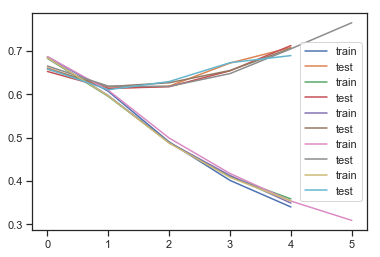

In [458]:
run(n_batch=64, n_epochs=15, n_neurons=10)

Train on 11037 samples, validate on 1227 samples
Epoch 1/15
11037/11037 [==============================] - 42s 4ms/sample - loss: 0.6773 - acc: 0.5757 - val_loss: 0.6488 - val_acc: 0.6333
Epoch 2/15
11037/11037 [==============================] - 40s 4ms/sample - loss: 0.5809 - acc: 0.7026 - val_loss: 0.6215 - val_acc: 0.6455
Epoch 3/15
11037/11037 [==============================] - 42s 4ms/sample - loss: 0.4889 - acc: 0.7735 - val_loss: 0.6340 - val_acc: 0.6536
Epoch 4/15
11037/11037 [==============================] - 42s 4ms/sample - loss: 0.4310 - acc: 0.8096 - val_loss: 0.6720 - val_acc: 0.6438
Epoch 5/15
11037/11037 [==============================] - 40s 4ms/sample - loss: 0.3851 - acc: 0.8310 - val_loss: 0.6972 - val_acc: 0.6512
Train on 11037 samples, validate on 1227 samples
Epoch 1/15
11037/11037 [==============================] - 41s 4ms/sample - loss: 0.6908 - acc: 0.5294 - val_loss: 0.6804 - val_acc: 0.5762
Epoch 2/15
11037/11037 [==============================] - 40s 4ms/sa

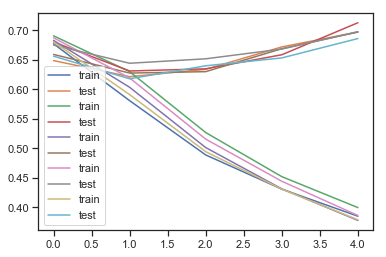

In [459]:
run(n_batch=64, n_epochs=15, n_neurons=1)

Train on 11037 samples, validate on 1227 samples
Epoch 1/15
11037/11037 [==============================] - 61s 6ms/sample - loss: 0.6822 - acc: 0.5492 - val_loss: 0.6477 - val_acc: 0.6316
Epoch 2/15
11037/11037 [==============================] - 59s 5ms/sample - loss: 0.5873 - acc: 0.6903 - val_loss: 0.5957 - val_acc: 0.6773
Epoch 3/15
11037/11037 [==============================] - 60s 5ms/sample - loss: 0.4791 - acc: 0.7719 - val_loss: 0.6071 - val_acc: 0.6699
Epoch 4/15
11037/11037 [==============================] - 60s 5ms/sample - loss: 0.3957 - acc: 0.8230 - val_loss: 0.6608 - val_acc: 0.6740
Epoch 5/15
11037/11037 [==============================] - 60s 5ms/sample - loss: 0.3307 - acc: 0.8555 - val_loss: 0.7345 - val_acc: 0.6504
Train on 11037 samples, validate on 1227 samples
Epoch 1/15
11037/11037 [==============================] - 63s 6ms/sample - loss: 0.6852 - acc: 0.5401 - val_loss: 0.6717 - val_acc: 0.5778
Epoch 2/15
11037/11037 [==============================] - 61s 6ms/sa

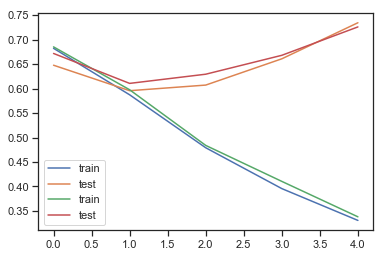

In [462]:
run(n_batch=64, n_epochs=15, n_neurons=100, n_repeats=2)

Train on 11037 samples, validate on 1227 samples
Epoch 1/15
11037/11037 [==============================] - 31s 3ms/sample - loss: 0.6929 - acc: 0.5086 - val_loss: 0.6918 - val_acc: 0.5428
Epoch 2/15
11037/11037 [==============================] - 26s 2ms/sample - loss: 0.6903 - acc: 0.5503 - val_loss: 0.6892 - val_acc: 0.5534
Epoch 3/15
11037/11037 [==============================] - 25s 2ms/sample - loss: 0.6849 - acc: 0.5729 - val_loss: 0.6833 - val_acc: 0.5705
Epoch 4/15
11037/11037 [==============================] - 25s 2ms/sample - loss: 0.6723 - acc: 0.6133 - val_loss: 0.6701 - val_acc: 0.6088
Epoch 5/15
11037/11037 [==============================] - 25s 2ms/sample - loss: 0.6463 - acc: 0.6579 - val_loss: 0.6550 - val_acc: 0.6186
Epoch 6/15
11037/11037 [==============================] - 26s 2ms/sample - loss: 0.6114 - acc: 0.6878 - val_loss: 0.6390 - val_acc: 0.6381
Epoch 7/15
11037/11037 [==============================] - 26s 2ms/sample - loss: 0.5657 - acc: 0.7212 - val_loss: 0.6

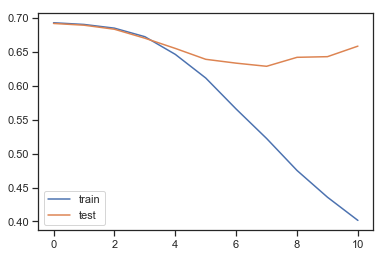

In [464]:
run(n_batch=2048, n_epochs=15, n_neurons=100, n_repeats=1)

Train on 11037 samples, validate on 1227 samples
Epoch 1/15
11037/11037 [==============================] - 11s 1ms/sample - loss: 0.6929 - acc: 0.5148 - val_loss: 0.6923 - val_acc: 0.5371
Epoch 2/15
11037/11037 [==============================] - 8s 734us/sample - loss: 0.6909 - acc: 0.5519 - val_loss: 0.6908 - val_acc: 0.5420
Epoch 3/15
11037/11037 [==============================] - 8s 755us/sample - loss: 0.6870 - acc: 0.5938 - val_loss: 0.6880 - val_acc: 0.5623
Epoch 4/15
11037/11037 [==============================] - 8s 737us/sample - loss: 0.6812 - acc: 0.6291 - val_loss: 0.6839 - val_acc: 0.5803
Epoch 5/15
11037/11037 [==============================] - 8s 729us/sample - loss: 0.6716 - acc: 0.6591 - val_loss: 0.6779 - val_acc: 0.6023
Epoch 6/15
11037/11037 [==============================] - 8s 759us/sample - loss: 0.6582 - acc: 0.6776 - val_loss: 0.6696 - val_acc: 0.6170
Epoch 7/15
11037/11037 [==============================] - 8s 726us/sample - loss: 0.6387 - acc: 0.7057 - val_los

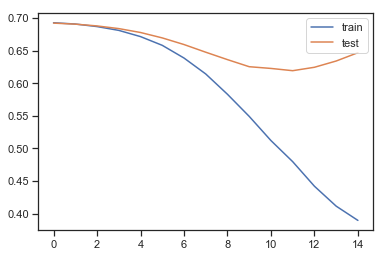

In [465]:
run(n_batch=2048, n_epochs=15, n_neurons=10, n_repeats=1)

Train on 11037 samples, validate on 1227 samples
Epoch 1/15
11037/11037 [==============================] - 54s 5ms/sample - loss: 0.6872 - acc: 0.5480 - val_loss: 0.6648 - val_acc: 0.6055
Epoch 2/15
11037/11037 [==============================] - 51s 5ms/sample - loss: 0.6062 - acc: 0.6801 - val_loss: 0.6239 - val_acc: 0.6487
Epoch 3/15
11037/11037 [==============================] - 53s 5ms/sample - loss: 0.4969 - acc: 0.7653 - val_loss: 0.6116 - val_acc: 0.6740
Epoch 4/15
11037/11037 [==============================] - 52s 5ms/sample - loss: 0.4236 - acc: 0.8051 - val_loss: 0.6594 - val_acc: 0.6528
Epoch 5/15
11037/11037 [==============================] - 52s 5ms/sample - loss: 0.3541 - acc: 0.8420 - val_loss: 0.6952 - val_acc: 0.6455
Epoch 6/15
11037/11037 [==============================] - 55s 5ms/sample - loss: 0.3108 - acc: 0.8621 - val_loss: 0.7602 - val_acc: 0.6512


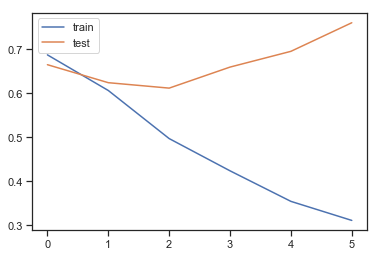

In [466]:
run(n_batch=128, n_epochs=15, n_neurons=100, n_repeats=1)

#### Best model parameters: epochs=15, batch_size=2048, n_neurons=100

In [472]:
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100

epochs = 15
batch_size =2048

model = Sequential()
# Embedding layer
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))

# Recurrent layer
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# Fully connected layer
model.add(keras.layers.Dense(64, activation='relu'))

# Dropout for regularization
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())

# Output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 11037 samples, validate on 1227 samples
Epoch 1/15
11037/11037 [==============================] - 30s 3ms/sample - loss: 0.6927 - acc: 0.5090 - val_loss: 0.6921 - val_acc: 0.5257
Epoch 2/15
11037/11037 [==============================] - 27s 2ms/sample - loss: 0.6907 - acc: 0.5319 - val_loss: 0.6898 - val_acc: 0.5469
Epoch 3/15
11037/11037 [==============================] - 27s 2ms/sample - loss: 0.6858 - acc: 0.5819 - val_loss: 0.6854 - val_acc: 0.5762
Epoch 4/15
11037/11037 [==============================] - 26s 2ms/sample - loss: 0.6747 - acc: 0.6181 - val_loss: 0.6738 - val_acc: 0.6064
Epoch 5/15
11037/11037 [==============================] - 26s 2ms/sample - loss: 0.6499 - acc: 0.6632 - val_loss: 0.6520 - val_acc: 0.6341
Epoch 6/15
11037/11037 [==============================] - 27s 2ms/sample - loss: 0.6092 - acc: 0.6857 - val_loss: 0.6410 - val_acc: 0.6300
Epoch 7/15
11037/11037 [==============================] - 26s 2ms/sample - loss: 0.5651 - acc: 0.7170 - val_loss: 0.6

In [473]:
model.evaluate(x_test, y_test)

3066/3066 [==============================] - 4s 1ms/sample - loss: 0.6896 - acc: 0.6507


[0.6896406077358821, 0.65068495]

In [478]:
print("Testing set accuracy for RNN: 65.01%")

Testing set accuracy for RNN: 65.01%
